In [1]:
from core import download_IC
from core import download_ATNF

In [2]:
from core import readfiles
import numpy as np
import pandas as pd
import os
import multiprocessing as mul
from multiprocessing import Process
import matplotlib.pyplot as plt
from scipy.stats import gaussian_kde
import scipy.stats as sct
from astropy.coordinates import SkyCoord as scr
from astropy import units as u
from time import sleep
from numba import jit, njit, prange
from tqdm import tqdm
from core.signal_bag import *
from core.stacking_analysis import *
from core.req_arrays import *
import bisect

read icdata
read uptdata
read eadata
read mspdata


In [17]:
# UNCOMMENT FOR LINEAR BINS
all_enu = np.linspace(10**11.001, 10**18.999, 1000)

# UNCOMMENT FOR LOGARITHMIC BINS
# all_enu = np.logspace(11.001, 18.999, 1000)

In [18]:
gamma_arr = [-1, -2.2, -2.5, -3]
phio = np.logspace(-38, -26, 1000) #CHANGING TO LINEAR BINS RESULTS IN STRAIGHT LINES

#Uncomment to compute the background PDF for all neutrinos as per eqn 9 of 2205.15963

#and store them at /data/all_Bi.dat

#then recomment it


all_Bi = signals(4).compute_background()
all_Bi.tofile(os.getcwd() + '/data/all_Bi.dat', sep=',')

In [5]:
all_Bi = np.loadtxt(os.getcwd() + '/data/all_Bi.dat', delimiter=',')

In [6]:
weight_obj =  [weights.weights(gamma).all_weights for gamma in gamma_arr]
sum_weights = [weights.weights(gamma).sum_weights for gamma in gamma_arr]

In [7]:
#Calculating weight/sum(weights) to avoid wrong ns = 0 entries 
normalized_wt = []
for gamma in range(4):
    temp = []
    for season in range(len(weight_obj[gamma])):
        temp.append(weight_obj[gamma][ea_season(season)]/sum_weights[gamma][ea_season(season)])
    normalized_wt.append(temp)

In [8]:
#Compute the signal PDF for all neutrinos as per eqns 6, 7 and weights as per eqn 8 of 2205.15963
all_Si = np.asfarray([signals(gamma_arr[i]).compute_signal() for i in tqdm(prange(4))])

100%|██████████| 4/4 [01:29<00:00, 22.44s/it]


In [10]:
#generates ns^ for a single pulsar a single season and a single energy

@njit(fastmath=True)
def ns_singleseason_sing_psr_HAT(dec,enu, gamma, phi0 = 1, season=0):
    '''
    This function returns the number of signal events for a single pulsar as in EQN3 of 2205.15963
    -------------------

    Parameters
    ----------
    dec : float
        The declination of the pulsar in radians
    
    enu : float
        The neutrino energy in eV

    gamma : float
        The spectral index of the neutrino flux

    phi0 : float (optional)
        The normalization constant of the neutrino flux

    season : int (optional)
        The IceCube season number
    
    Returns
    -------
    float
        The number of signal events for the given parameters
    '''


    tt_upt = t_upt[season]
    if enu <= 1e11 or enu >= 1e19:
        return 0.0
    else:
        k=0
        l=0
        for i in range(0, len(e_nu_wall)):
            if e_nu_wall[i] <= enu and e_nu_wall[i+1] > enu:
                for j in range(0, len(dec_nu)):
                    if dec_nu[j] <= dec and dec_nu[j+1] > dec:
                        k=i
                        l=j
                        break
                break

        temp_ea = np.asarray(earea[ea_season(season)])[l*40 + k]
        return tt_upt * temp_ea * dfde(enu, gamma, phi0)     #in s cm2 eV


In [19]:
#For each gamma, find ns and find TS(ns*phi0)
#FIND TS as in eqn 3 of 2205.15963

#28032023 SD suggestion - USE trapz

all_TSS = []
all_TSS_with_wt = []
nss_all_gamma = []
for gamma in prange(4):
    nss_all_eng = []
    psrns = 0
    for psrdec in range(p):
        for season in prange(10):
            tmp = [ns_singleseason_sing_psr_HAT(msdec[psrdec], all_enu[i], gamma_arr[gamma], 1 ,season=season) for i in range(len(all_enu))]
            psrns += np.trapz(y=tmp, x=all_enu)
    nss_all_eng.append(psrns)
    
    @njit
    def TS_for_all_psrs2(nsa):  
        return Ts_arr2(nsa, all_Si[gamma], all_Bi, Ns)      #No units

    pool = mul.Pool(12, maxtasksperchild=200)
    op_arr = pool.map_async(TS_for_all_psrs2, nss_all_eng*phio) #No units
    temp = op_arr.get()
    pool = []
    op_arr = []
    all_TSS.append(temp)

    nss_all_gamma.append(nss_all_eng)

In [20]:
nss_all_gamma #without weights

[[1.138323044436885e+34],
 [6.130192994319949e+34],
 [4.8655763967923e+35],
 [1.5368561621733955e+37]]

### $N \approx 10^6$

In [21]:
#For each gamma, find ns and find TS(ns*phi0)
#FIND TS as in eqn 3 of 2205.15963

#28032023 SD suggestion - USE trapz

# all_TSS = []
all_TSS_with_wt = []
nss_all_gamma = []
for gamma in prange(4):
    nss_all_eng = []
    psrns = 0
    for psrdec in range(p):
        for season in prange(10):    
            # for enu in range(len(all_enu)):
            wt = normalized_wt[gamma][ea_season(season)][psrdec]
            tmp = [wt * ns_singleseason_sing_psr_HAT(msdec[psrdec], all_enu[i], gamma_arr[gamma], 1 ,season=season) for i in range(len(all_enu))]
            psrns += np.trapz(y=tmp, x=all_enu)
    nss_all_eng.append(psrns)
    
    @njit
    def TS_for_all_psrs2(nsa):  
        return Ts_arr2(nsa, all_Si[gamma], all_Bi, Ns)      #No units

    pool = mul.Pool(12, maxtasksperchild=200)
    op_arr = pool.map_async(TS_for_all_psrs2, nss_all_eng*phio) #No units
    temp = op_arr.get()
    pool = []
    op_arr = []
    all_TSS_with_wt.append(temp)

    # nss_all_gamma.append(nss_all_eng)

In [22]:
for i in range(4):
    print(min(all_TSS[i]), max(all_TSS[i]))

-7121110.4284146 -5.929625358492535e-07
-6879478.163537655 0.3108076868872383
-6768302.299525939 0.39718753574634
-6527450.660807848 0.41845337496724555


In [23]:
for i in range(4):
    print(min(all_TSS_with_wt[i]), max(all_TSS_with_wt[i]))

-15948.536460791935 -1.6915224780511833e-10
-203293.49550584186 0.31080513089380657
-8614729.02928404 0.39723619009192485
-7806014.213697603 0.41842310004929645


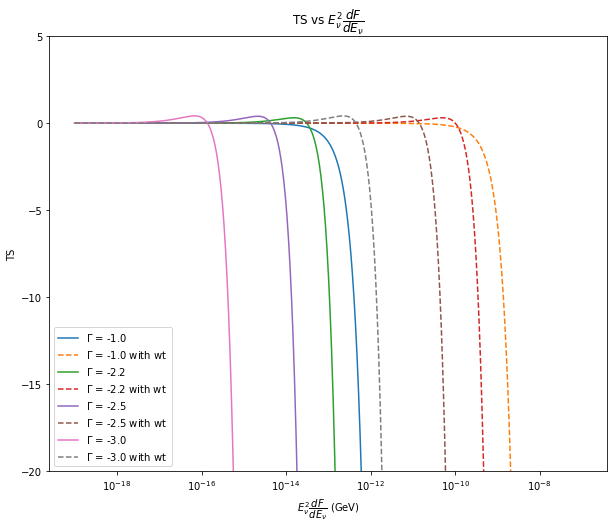

In [24]:
#Plotting

all_TSS = np.asarray(all_TSS)
gamma_arr = np.asarray(gamma_arr)
e2dfde = []

for i in prange(4):
    temp = []
    for phi in range(len(phio)):
        temp.append( 1e28 * dfde(1e14, gamma_arr[i], phio[phi]))        #in eV
    e2dfde.append(temp)

e2dfde = np.asarray(e2dfde)
mark = ['^', 'o', 's', 'd']
plt.figure(figsize=(10,8))
for i in [0, 1, 2, 3]:#range(4):
    plt.plot(e2dfde[i]/1e9, all_TSS[i], label='$\Gamma$ = ' + str(gamma_arr[i]))    #in GeV
    plt.plot(e2dfde[i]/1e9, all_TSS_with_wt[i], ls='--',label='$\Gamma$ = ' + str(gamma_arr[i]) + ' with wt')    #in GeV

plt.legend()
plt.xscale('log')
plt.xlabel('$E^2_{\u03BD} \dfrac{dF}{dE_{\u03BD}}$ (GeV)')
plt.ylabel('TS')
plt.title('TS vs $E^2_{\u03BD} \dfrac{dF}{dE_{\u03BD}}$')
# plt.xlim(1e-30, 1e-22)
plt.ylim(-20, 5)
plt.show()